In [33]:
from __future__ import division
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch, tukey

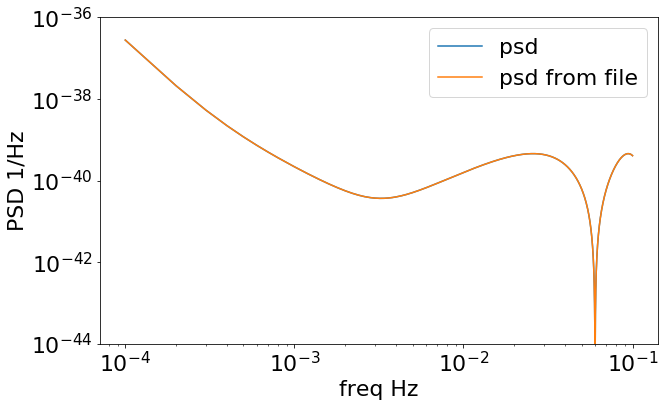

In [34]:
def psd_noise(freqs, plot=0):
    
    data = np.loadtxt('lisa_psd.txt')
    f_req, psd_req = data[:, 0], data[:, 1]
    
    psd = np.interp(freqs, f_req, np.log10(psd_req))
    psd = 10**psd
    
    
    if plot:
        plt.loglog(freqs, psd, label='psd')
        plt.loglog(f_req, psd_req, label='psd from file')
        plt.legend()
        plt.ylim([1e-44, 1e-36])
        plt.xlabel('freq Hz')
        plt.ylabel('PSD 1/Hz')
    else:
        return psd
    
## --------------------------------
psd_noise(freqs=np.arange(1e-4, 1e-1, 1e-4), plot=1)

In [35]:
def random_noise(dur=int(1e5), fs=0.25):
    
        # Number of data points in the time series
        N = int(fs*dur)

        # prepare for FFT
        if  np.mod(N,2)== 0 :
            numFreqs = N/2 - 1;
        else:
            numFreqs = (N-1)/2;

        # We will make an array of the desired frequencies
        fout = np.fft.rfftfreq(N, 1.0/fs)
    
        fmin = fout[0], fout[-1]


        Sh = psd_noise(fout, plot=0)

    
        # Amplitude for for ifft
        norms = np.sqrt(Sh*fs*N)/2.0

        # Normally distributed in frequency space
        re1 = norms*np.random.normal(size=fout.size)
        im1 = norms*np.random.normal(size=fout.size)

        htilda = re1 + 1j*im1

        # Take inverse fft to get time series data
        ht = np.real(np.fft.irfft(htilda, N))

        return ht

In [36]:
def corr_calc(dur=1e5, segDur=1e4, fs=0.25, f1=1e-4, f2=1e-1, type='singletime'):
        
        nperseg = int(fs*segDur)
        
        d1 = random_noise(dur=dur, fs=fs)
        
        nsegs = int(dur/segDur)
        
        fftfreqs = np.fft.rfftfreq(nperseg, 1.0/fs)
        
        # intitialize arraus
        rfft = np.zeros((fftfreqs.size, nsegs), dtype='complex')
        
        ## windowing stuff
        #hwin = np.hanning(nperseg)
        hwin = tukey(nperseg, 0.5)
        win_fact = np.mean(hwin**2)
    
        for ii in range(nsegs):
            
            idxmin = int(ii*nperseg)
            idxmax = nperseg +idxmin
            
            rfft[:, ii] = np.fft.rfft(hwin*d1[idxmin:idxmax])
            

        rfft = np.sqrt(2.0/(win_fact*segDur))*rfft/(fs)
        
        ## Measure covariance
        r1, r2 = rfft[fftfreqs == f1] , rfft[fftfreqs == f2]   
        
        
        if type=='singletime':
            
            cov_r = np.real(np.conj(r2)*r1)
            cov_i = np.imag(np.conj(r2)*r1)
            
        
        elif type == 'crosstime':
            
            R1, R2 = np.meshgrid(r1, r2)
            
            cov_r = np.real(np.conj(R2)*R1)
            cov_i = np.imag(np.conj(R2)*R1)
        
        
            for ii in range(nsegs):
                cov_r[ii, ii] = np.nan
                cov_i[ii, ii] = np.nan
        
        elif type == 'nearest-neighbour':
            
            R1, R2 = np.meshgrid(r1, r2)
            
            cov_R = np.real(np.conj(R2)*R1)
            cov_I = np.imag(np.conj(R2)*R1)
        
            cov_r = np.concatenate((np.diagonal(cov_R, offset=1),np.diagonal(cov_R, offset=-1) ))
            cov_i = np.concatenate((np.diagonal(cov_I, offset=1),np.diagonal(cov_I, offset=-1) ))
    
        cov_r = cov_r.flatten()
        cov_i = cov_i.flatten()
        
        cov_r = cov_r[~np.isnan(cov_r)]
        cov_i = cov_i[~np.isnan(cov_i)]
        

        
        plt.subplot(1, 2, 1)
        plt.hist(cov_r, bins=50)
        plt.yscale('log')
        plt.xlabel('real part')
        plt.axvline(0, color='r')
        
        plt.subplot(1, 2, 2)
        plt.hist(cov_i, bins=50)
        plt.yscale('log')
        plt.xlabel('imaginary part')
        plt.axvline(0, color='r')
        plt.savefig('noi_corr.pdf', dpi=150)
        
        return cov_r, cov_i

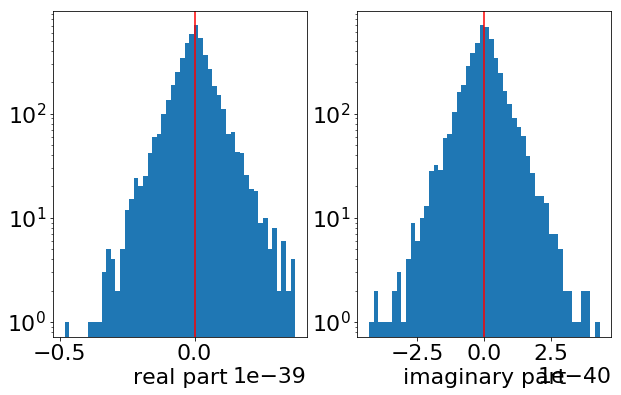

In [37]:
cov_r, cov_i = corr_calc(dur=5e7, segDur = 1e4, f1=1e-3, f2=2e-3, type='singletime')

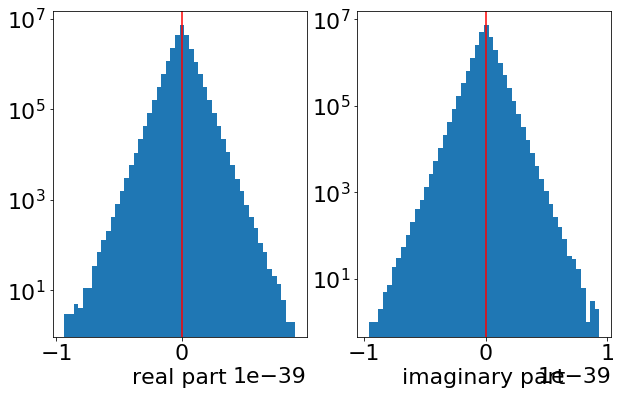

In [39]:
cov_r, cov_i = corr_calc(dur=5e7, segDur = 1e4, f1=1e-3, f2=2e-3, type='crosstime')

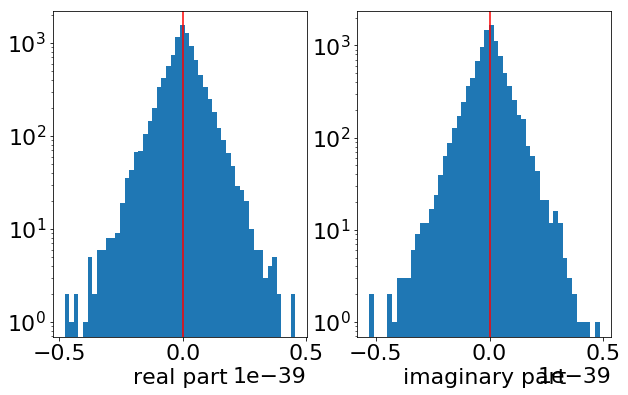

In [40]:
cov_r, cov_i = corr_calc(dur=5e7, segDur = 1e4, f1=1e-3, f2=2e-3, type='nearest-neighbour')

In [ ]:
## Correlation between 650 Hz and 651 Hz at the same time segment. 
freqs, cov_r, cov_i = corr_calc(dur=2000, segDur = 4, f1=650, f2=651, type='crosstime')

In [ ]:
## Correlation between 650 Hz and 700 Hz across all time segments
freqs, cov_r, cov_i = corr_calc(dur=2000, segDur = 4, f1=650, f2=700, type='crosstime')

In [1]:
## Correlation between 650 Hz and 650 Hz across all time segments
freqs, cov_r, cov_i = corr_calc(dur=2000, segDur = 4, f1=650, f2=650, type='crosstime')

NameError: name 'corr_calc' is not defined

In [ ]:
## Correlation between 650 Hz and 650 Hz across all time segments
freqs, cov_r, cov_i = corr_calc(dur=20000, segDur = 4, f1=650, f2=650, type='nearest-neighbour')